# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import GAN_additional_helper

GAN_additional_helper.download_extract('mnist', data_dir)
GAN_additional_helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

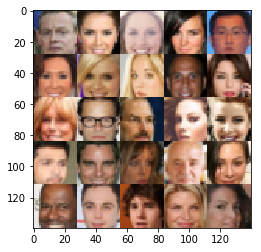

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name=('input_real'))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate
## Found in the forum that the error output is fine

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [141]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        h1 = tf.layers.conv2d(images, 64,5, strides=2, padding='same')
        x1 = tf.maximum(alpha * h1, h1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        #flatten = tf.reshape(x2, (-1, 7*7*256))
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return (out, logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [142]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x21 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x21 = tf.layers.batch_normalization(x21, training=is_train)
        x21 = tf.maximum(alpha * x21, x21)
        #7x7x256
        x2 = tf.layers.conv2d_transpose(x21, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now


        # Ouput layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [143]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    
    dis_model_generated, dis_logits_generated = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real)))
    dis_loss_generated = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_generated, labels=tf.zeros_like(dis_model_generated)))

    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_generated, labels=tf.ones_like(dis_model_generated)))

    dis_loss = dis_loss_real + dis_loss_generated
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [144]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
        # Optimizers
    #learning_rate = 0.002

    tvars = tf.trainable_variables()
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt
 
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [145]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [146]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    step = 0
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images.reshape(batch_size, image_width, image_height, image_channels)
                batch_images *=2

                # random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                #optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, lr:learning_rate
                                               })

                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if step == 1:
                        print('initial output')
                        show_generator_output(sess,25,input_z,image_channels,data_image_mode)
                if step % 20 == 0:
                        train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,
                                                        input_z:batch_z,
                                                        lr:learning_rate})
                        train_loss_g = sess.run(g_loss,feed_dict={input_real:batch_images,
                                                        input_z:batch_z,
                                                        lr:learning_rate})
                        print('Epochs {},batches {}, dis_loss {} , gen_loss {}'.format(epoch_i+1,step,train_loss_d,train_loss_g))
                if step %100 == 0:
                        show_generator_output(sess,25,input_z,image_channels,data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output


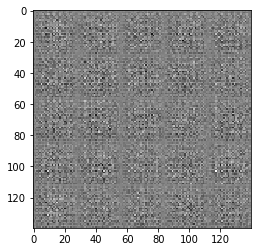

Epochs 1,batches 20, dis_loss 0.6553948521614075 , gen_loss 1.0109012126922607
Epochs 1,batches 40, dis_loss 1.5470458269119263 , gen_loss 1.6397337913513184
Epochs 1,batches 60, dis_loss 0.47519510984420776 , gen_loss 1.9560127258300781
Epochs 1,batches 80, dis_loss 0.8039442896842957 , gen_loss 0.7683555483818054
Epochs 1,batches 100, dis_loss 1.2875975370407104 , gen_loss 0.4271301031112671


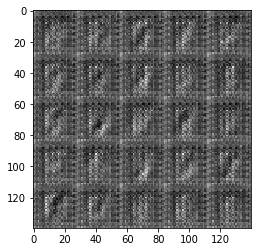

Epochs 1,batches 120, dis_loss 1.2090412378311157 , gen_loss 0.455337792634964
Epochs 1,batches 140, dis_loss 0.8851782083511353 , gen_loss 0.7762612104415894
Epochs 1,batches 160, dis_loss 1.1076844930648804 , gen_loss 0.5108457207679749
Epochs 1,batches 180, dis_loss 0.9572119116783142 , gen_loss 0.6352901458740234
Epochs 1,batches 200, dis_loss 0.9742813110351562 , gen_loss 0.6029528975486755


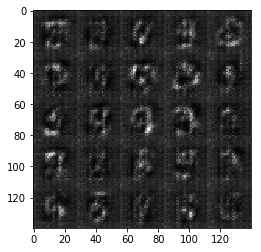

Epochs 1,batches 220, dis_loss 0.9191645383834839 , gen_loss 0.6867367625236511
Epochs 1,batches 240, dis_loss 0.8300203084945679 , gen_loss 0.7591208219528198
Epochs 1,batches 260, dis_loss 1.187453269958496 , gen_loss 0.4371277093887329
Epochs 1,batches 280, dis_loss 0.8540041446685791 , gen_loss 0.7059674263000488
Epochs 1,batches 300, dis_loss 0.9398974180221558 , gen_loss 0.637952446937561


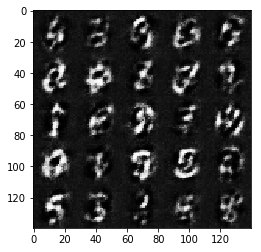

Epochs 1,batches 320, dis_loss 0.9160720109939575 , gen_loss 0.6838343739509583
Epochs 1,batches 340, dis_loss 0.8696364164352417 , gen_loss 0.7201666235923767
Epochs 1,batches 360, dis_loss 0.834021806716919 , gen_loss 0.7892856597900391
Epochs 1,batches 380, dis_loss 0.9409161806106567 , gen_loss 0.6043922901153564
Epochs 1,batches 400, dis_loss 0.8829452991485596 , gen_loss 0.7014086842536926


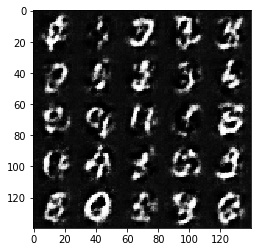

Epochs 1,batches 420, dis_loss 1.1595451831817627 , gen_loss 0.45634061098098755
Epochs 1,batches 440, dis_loss 0.9843305945396423 , gen_loss 0.5856848955154419
Epochs 1,batches 460, dis_loss 0.8859876394271851 , gen_loss 0.7107982039451599
Epochs 2,batches 480, dis_loss 1.1839746236801147 , gen_loss 0.43931782245635986
Epochs 2,batches 500, dis_loss 1.1279957294464111 , gen_loss 0.511543333530426


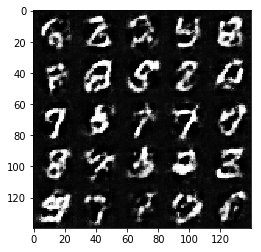

Epochs 2,batches 520, dis_loss 0.9654555320739746 , gen_loss 0.6207388043403625
Epochs 2,batches 540, dis_loss 1.2971112728118896 , gen_loss 0.39736950397491455
Epochs 2,batches 560, dis_loss 1.2018324136734009 , gen_loss 0.4302937388420105
Epochs 2,batches 580, dis_loss 1.070580244064331 , gen_loss 0.5422649383544922
Epochs 2,batches 600, dis_loss 0.9998478889465332 , gen_loss 0.5985158681869507


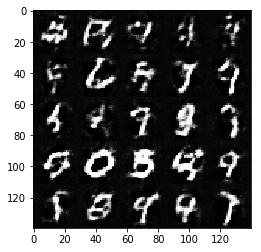

Epochs 2,batches 620, dis_loss 1.0174262523651123 , gen_loss 1.6276562213897705
Epochs 2,batches 640, dis_loss 1.0655531883239746 , gen_loss 1.353895664215088
Epochs 2,batches 660, dis_loss 0.9151319861412048 , gen_loss 0.8165488243103027
Epochs 2,batches 680, dis_loss 1.2643612623214722 , gen_loss 0.41905736923217773
Epochs 2,batches 700, dis_loss 1.0804071426391602 , gen_loss 0.6159286499023438


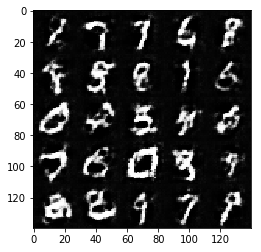

Epochs 2,batches 720, dis_loss 1.0590577125549316 , gen_loss 0.5770399570465088
Epochs 2,batches 740, dis_loss 0.962653398513794 , gen_loss 0.8171201944351196
Epochs 2,batches 760, dis_loss 1.2321574687957764 , gen_loss 0.43562963604927063
Epochs 2,batches 780, dis_loss 1.3313320875167847 , gen_loss 0.375318318605423
Epochs 2,batches 800, dis_loss 1.056274652481079 , gen_loss 0.6428471803665161


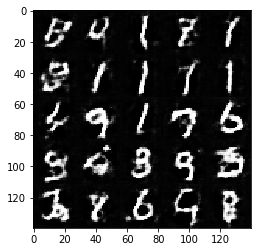

Epochs 2,batches 820, dis_loss 1.4049358367919922 , gen_loss 0.3605514168739319
Epochs 2,batches 840, dis_loss 1.3800984621047974 , gen_loss 1.920737385749817
Epochs 2,batches 860, dis_loss 1.1391832828521729 , gen_loss 1.5847148895263672
Epochs 2,batches 880, dis_loss 1.129321575164795 , gen_loss 1.4213175773620605
Epochs 2,batches 900, dis_loss 1.08355712890625 , gen_loss 1.3663854598999023


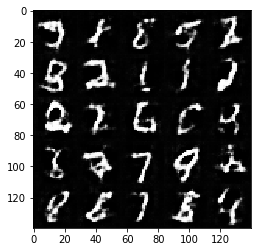

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output


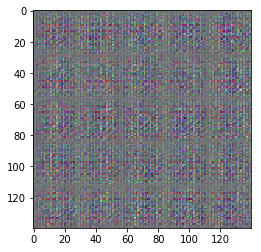

Epochs 1,batches 20, dis_loss 0.8987470865249634 , gen_loss 0.8057702779769897
Epochs 1,batches 40, dis_loss 1.1952683925628662 , gen_loss 0.4769001007080078
Epochs 1,batches 60, dis_loss 0.8122043609619141 , gen_loss 0.8619557023048401
Epochs 1,batches 80, dis_loss 1.197231650352478 , gen_loss 0.7776523232460022
Epochs 1,batches 100, dis_loss 1.0249208211898804 , gen_loss 1.5922231674194336


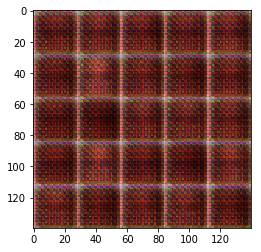

Epochs 1,batches 120, dis_loss 1.3683571815490723 , gen_loss 0.44122588634490967
Epochs 1,batches 140, dis_loss 0.8322726488113403 , gen_loss 0.8904328346252441
Epochs 1,batches 160, dis_loss 1.0398449897766113 , gen_loss 1.0527136325836182
Epochs 1,batches 180, dis_loss 0.9530905485153198 , gen_loss 0.8750616312026978
Epochs 1,batches 200, dis_loss 1.1651315689086914 , gen_loss 0.7709375023841858


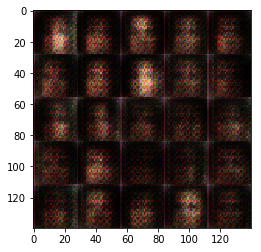

Epochs 1,batches 220, dis_loss 1.199861764907837 , gen_loss 0.5694425106048584
Epochs 1,batches 240, dis_loss 1.172197699546814 , gen_loss 0.6882877349853516
Epochs 1,batches 260, dis_loss 1.090277910232544 , gen_loss 1.0357451438903809
Epochs 1,batches 280, dis_loss 1.3252769708633423 , gen_loss 1.4598468542099
Epochs 1,batches 300, dis_loss 1.1405165195465088 , gen_loss 0.9760702848434448


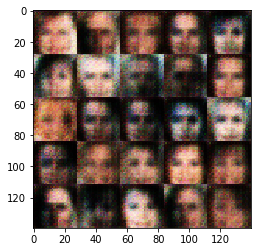

Epochs 1,batches 320, dis_loss 1.0422154664993286 , gen_loss 0.9146297574043274
Epochs 1,batches 340, dis_loss 1.5584373474121094 , gen_loss 0.3679317533969879
Epochs 1,batches 360, dis_loss 1.1051304340362549 , gen_loss 0.6573837399482727
Epochs 1,batches 380, dis_loss 1.0490691661834717 , gen_loss 0.9548231959342957
Epochs 1,batches 400, dis_loss 1.2949373722076416 , gen_loss 0.49518883228302


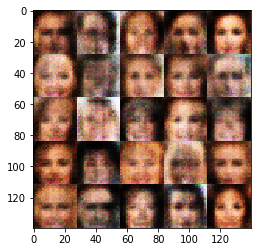

Epochs 1,batches 420, dis_loss 1.16116201877594 , gen_loss 0.7389056086540222
Epochs 1,batches 440, dis_loss 1.2843341827392578 , gen_loss 1.0595861673355103
Epochs 1,batches 460, dis_loss 1.3731892108917236 , gen_loss 1.1978970766067505
Epochs 1,batches 480, dis_loss 1.2129582166671753 , gen_loss 1.0624825954437256
Epochs 1,batches 500, dis_loss 1.284536600112915 , gen_loss 1.1164900064468384


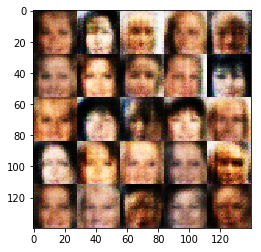

Epochs 1,batches 520, dis_loss 1.2459715604782104 , gen_loss 0.8335145711898804
Epochs 1,batches 540, dis_loss 1.5140433311462402 , gen_loss 0.3832423686981201
Epochs 1,batches 560, dis_loss 1.5232665538787842 , gen_loss 0.3720351457595825
Epochs 1,batches 580, dis_loss 1.3969149589538574 , gen_loss 0.43402063846588135
Epochs 1,batches 600, dis_loss 1.2694309949874878 , gen_loss 0.611465573310852


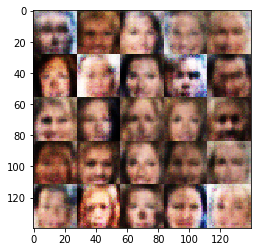

Epochs 1,batches 620, dis_loss 1.5342350006103516 , gen_loss 0.352777361869812
Epochs 1,batches 640, dis_loss 1.3529024124145508 , gen_loss 0.4995100498199463
Epochs 1,batches 660, dis_loss 1.32368803024292 , gen_loss 1.2526978254318237
Epochs 1,batches 680, dis_loss 1.1690857410430908 , gen_loss 0.8958220481872559
Epochs 1,batches 700, dis_loss 1.3837380409240723 , gen_loss 1.01072359085083


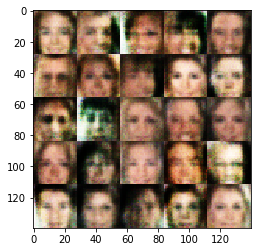

Epochs 1,batches 720, dis_loss 1.102916955947876 , gen_loss 1.4226677417755127
Epochs 1,batches 740, dis_loss 1.2279479503631592 , gen_loss 0.8040232062339783
Epochs 1,batches 760, dis_loss 1.4383307695388794 , gen_loss 1.2166798114776611
Epochs 1,batches 780, dis_loss 1.4105781316757202 , gen_loss 0.4843651056289673
Epochs 1,batches 800, dis_loss 1.2132368087768555 , gen_loss 0.9540086984634399


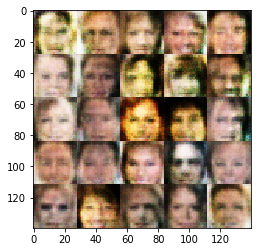

Epochs 1,batches 820, dis_loss 1.252528429031372 , gen_loss 0.561309814453125
Epochs 1,batches 840, dis_loss 1.3545722961425781 , gen_loss 0.5655090808868408
Epochs 1,batches 860, dis_loss 1.234474778175354 , gen_loss 0.7724688649177551
Epochs 1,batches 880, dis_loss 1.2506589889526367 , gen_loss 0.7244414687156677
Epochs 1,batches 900, dis_loss 1.2193338871002197 , gen_loss 0.6741730570793152


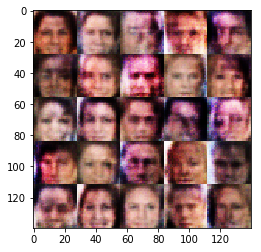

Epochs 1,batches 920, dis_loss 1.4767745733261108 , gen_loss 0.45769187808036804
Epochs 1,batches 940, dis_loss 1.354330062866211 , gen_loss 1.1123309135437012
Epochs 1,batches 960, dis_loss 1.3829623460769653 , gen_loss 1.189816951751709
Epochs 1,batches 980, dis_loss 1.399638056755066 , gen_loss 0.49610745906829834
Epochs 1,batches 1000, dis_loss 1.3152211904525757 , gen_loss 1.1138999462127686


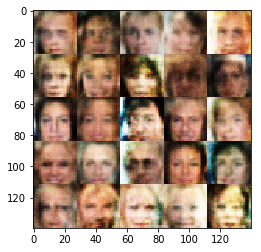

Epochs 1,batches 1020, dis_loss 1.2019271850585938 , gen_loss 0.7763689756393433
Epochs 1,batches 1040, dis_loss 1.331892728805542 , gen_loss 0.9246710538864136
Epochs 1,batches 1060, dis_loss 1.2682081460952759 , gen_loss 0.9091840982437134
Epochs 1,batches 1080, dis_loss 1.3127284049987793 , gen_loss 1.037916660308838
Epochs 1,batches 1100, dis_loss 1.1733468770980835 , gen_loss 0.9174965620040894


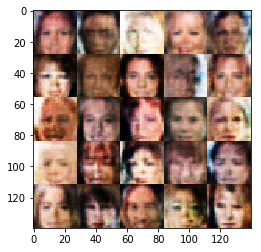

Epochs 1,batches 1120, dis_loss 1.372542142868042 , gen_loss 1.0348491668701172
Epochs 1,batches 1140, dis_loss 1.2301499843597412 , gen_loss 0.9229384660720825
Epochs 1,batches 1160, dis_loss 1.1811933517456055 , gen_loss 0.8852333426475525
Epochs 1,batches 1180, dis_loss 1.315157175064087 , gen_loss 0.627489447593689
Epochs 1,batches 1200, dis_loss 1.3762953281402588 , gen_loss 1.0036121606826782


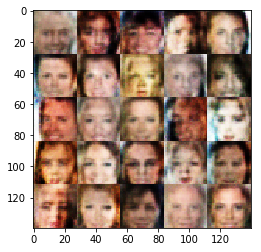

Epochs 1,batches 1220, dis_loss 1.3635752201080322 , gen_loss 0.7689170241355896
Epochs 1,batches 1240, dis_loss 1.403916597366333 , gen_loss 0.43104827404022217
Epochs 1,batches 1260, dis_loss 1.2787532806396484 , gen_loss 0.6353070735931396
Epochs 1,batches 1280, dis_loss 1.3666421175003052 , gen_loss 1.1018822193145752
Epochs 1,batches 1300, dis_loss 1.3426457643508911 , gen_loss 0.5036177039146423


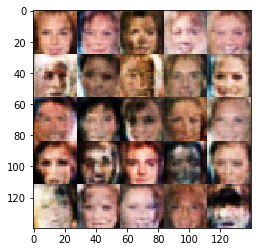

Epochs 1,batches 1320, dis_loss 1.2873449325561523 , gen_loss 0.6976779699325562
Epochs 1,batches 1340, dis_loss 1.2463080883026123 , gen_loss 0.7992379069328308
Epochs 1,batches 1360, dis_loss 1.416250228881836 , gen_loss 0.9160639047622681
Epochs 1,batches 1380, dis_loss 1.338365077972412 , gen_loss 0.7123215198516846
Epochs 1,batches 1400, dis_loss 1.2456616163253784 , gen_loss 0.7123081088066101


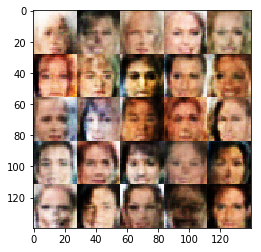

Epochs 1,batches 1420, dis_loss 1.3700686693191528 , gen_loss 0.8269940614700317
Epochs 1,batches 1440, dis_loss 1.3743561506271362 , gen_loss 0.5923428535461426
Epochs 1,batches 1460, dis_loss 1.3313024044036865 , gen_loss 0.5183289051055908
Epochs 1,batches 1480, dis_loss 1.2979308366775513 , gen_loss 0.5253416299819946
Epochs 1,batches 1500, dis_loss 1.2481627464294434 , gen_loss 0.763214111328125


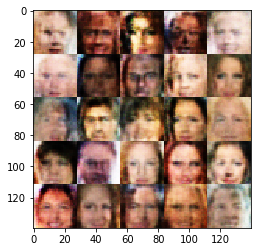

Epochs 1,batches 1520, dis_loss 1.2662127017974854 , gen_loss 0.8797323703765869
Epochs 1,batches 1540, dis_loss 1.2533148527145386 , gen_loss 1.1528823375701904
Epochs 1,batches 1560, dis_loss 1.3255788087844849 , gen_loss 0.8063077926635742
Epochs 1,batches 1580, dis_loss 1.3813408613204956 , gen_loss 0.9646170139312744


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.